# Text adventure game

This Python notebook builds a simple text advenutre game inspired by the [Adventuron Classroom](https://adventuron.io/classroom/) design by Chris Ainsley of Adventuron Software Limited.

The main components are:
1. __The parser__, which interprets the player's commands.
2. __The game__, which represents the world (a collection of __locations__ and __items__), and describes what the player sees.
3. __The data__, which you input to create your own unique game.

## The Game Class
The game keeps track of the state of the world, and describes what the player sees as they move through different locations.

In [0]:
class Game:
  """The Game class represents the world.  Internally, we use a 
     graph of Location objects and Item objects, which can be at a 
     Location or in the player's inventory.  Each locations has a set of
     exits which are the directions that a player can move to get to an
     adjacent location. The player can move from one location to another
     location by typing a command like "Go North".
  """

  def __init__(self, start_at):
    # start_at is the location in the game where the player starts
    self.curr_location = start_at
    self.curr_location.has_been_visited = True
    # inventory is the set of objects that the player has collected/
    self.inventory = {}
    # Print the special commands associated with items in the game (helpful 
    # for debugging and for novice players).
    self.print_commands = True

  def describe(self):
    """Describe the current game state by first describing the current 
       location, then listing any exits, and then describing any objects
       in the current location."""
    self.describe_current_location()
    self.describe_exits()
    self.describe_items()

  def describe_current_location(self):
    """Describe the current location by printing its description field."""
    print(self.curr_location.description)

  def describe_exits(self):
    """List the directions that the player can take to exit from the current
       location."""
    exits = []
    for exit in self.curr_location.connections.keys():
      exits.append(exit.capitalize())
    if len(exits) > 0:
      print("Exits: ", end = '')
      print(*exits, sep = ", ",)
  
  def describe_items(self):
    """Describe what objects are in the current location."""
    if len(self.curr_location.items) > 0:
      print("You see: ")
      for item_name in self.curr_location.items:
        item = self.curr_location.items[item_name]
        print(item.description)
        if self.print_commands:
          special_commands = item.get_commands()
          for cmd in special_commands:
            print('\t', cmd)

  def add_to_inventory(self, item):
    """Add an item to the player's inventory."""
    self.inventory[item.name] = item
  
  def is_in_inventory(self,item):
    return item.name in self.inventory

  def get_items_in_scope(self):
    """Returns a list of items in the current location and in the inventory"""
    items_in_scope = []
    for item_name in self.curr_location.items:
      items_in_scope.append(self.curr_location.items[item_name])
    for item_name in self.inventory:
      items_in_scope.append(self.inventory[item_name])
    return items_in_scope

## Locations

Locations Locations are the places in the game that a player can visit.  They contain connects to other locations and items that the player can interact with.

In [0]:
class Location:
  """Locations are the places in the game that a player can visit.
     Internally they are represented nodes in a graph.  Each location stores
     a description of the location, any items in the location, its connections
     to adjacent locations, and any blocks that prevent movement to an adjacent
     location.  The connections is a dictionary whose keys are directions and
     whose values are the location that is the result of traveling in that 
     direction.  The travel_descriptions also has directions as keys, and its 
     values are an optional short desciption of traveling to that location.
  """
  def __init__(self, name, description, end_game=False):
    # A short name for the location
    self.name = name
    # A description of the location
    self.description = description
    # True if entering this location should end the game
    self.end_game = end_game
    # Dictionary mapping from directions to other Location objects
    self.connections = {}
    # Dictionary mapping from directions to text description of the path there
    self.travel_descriptions = {}
    # Dictionary mapping from item name to Item objects present in this location
    self.items = {}
    # Dictionary mapping from direction to Block object in that direction
    self.blocks = {}
    # Flag that gets set to True once this location has been visited by player
    self.has_been_visited = False

    self.entrance_events = []
    self.exit_events = []

  def add_connection(self, direction, connected_location, travel_description=""):
    """Add a connection from the current location to a connected location.
       Direction is a string that the player can use to get to the connected
       location.  If the direction is a cardinal direction, then we also 
       automatically make a connection in the reverse direction."""
    self.connections[direction] = connected_location
    self.travel_descriptions[direction] = travel_description
    if direction == 'north':
      connected_location.connections["south"] = self
      connected_location.travel_descriptions["south"] = ""
    if direction == 'south':
      connected_location.connections["north"] = self
      connected_location.travel_descriptions["north"] = ""
    if direction == 'east':
      connected_location.connections["west"] = self
      connected_location.travel_descriptions["west"] = ""
    if direction == 'west':
      connected_location.connections["east"] = self
      connected_location.travel_descriptions["east"] = ""
    if direction == 'up':
      connected_location.connections["down"] = self
      connected_location.travel_descriptions["down"] = ""
    if direction == 'down':
      connected_location.connections["up"] = self
      connected_location.travel_descriptions["up"] = ""
    if direction == 'in':
      connected_location.connections["out"] = self
      connected_location.travel_descriptions["out"] = ""
    if direction == 'out':
      connected_location.connections["in"] = self
      connected_location.travel_descriptions["in"] = ""


  def add_item(self, name, item):
    """Put an item in this location."""
    self.items[name] = item

  def remove_item(self, item):
    """Remove an item from this location (for instance, if the player picks it
       up and puts it in their inventory)."""
    self.items.pop(item.name)


  def is_blocked(self, direction, game):
    """Check to if there is an obstacle in this direction."""
    if not direction in self.blocks:
        return False
    (block_description, preconditions) = self.blocks[direction]
    if check_preconditions(preconditions, game):
      # All the preconditions have been met.  You may pass.
      return False
    else: 
      # There are still obstalces to overcome or puzzles to solve.
      return True

  def remove_block(self, direction, game):
    self.blocks.pop("direction", None) 
    

  def get_block_description(self, direction):
    """Check to if there is an obstacle in this direction."""
    if not direction in self.blocks:
      return ""
    else:
      (block_description, preconditions) = self.blocks[direction]
      return block_description

  def add_block(self, blocked_direction, block_description, preconditions):
    """Create an obstacle that prevents a player from moving in the blocked 
       location until the preconditions are all met."""
    self.blocks[blocked_direction] = (block_description, preconditions)
  
  def add_entrance_event(self, function, args = ()):
    self.entrance_events.append((function, args))

  def add_exit_event(self, function, args = ()):
    self.exit_events.append((function, args))

  def perform_exit_events(self):
    for function, args in self.exit_events:
      function(args)
    self.exit_events.clear()

  def perform_entrance_events(self):
    for function, args in self.entrance_events:
      function(args)
    self.entrance_events.clear()
  


## Checking Preconditions 
In text adventure games it's common to block a player's progress by creating blocks that prevent them from moving to a location.  For instance, a drawbridge might have a troll that you need to get rig of before you can cross into the castle, or a locked door might prevent you from entering a building until you have a key.  

This is a function that you can modify to include other preconditions.

In [0]:
def check_preconditions(preconditions, game, print_failure_reasons=True):
  """Checks whether the player has met all of the specified preconditions"""
  all_conditions_met = True
  for check in preconditions: 
    if check == "inventory_contains":
      item = preconditions[check]
      if not game.is_in_inventory(item):
        all_conditions_met = False
        if print_failure_reasons:
          print("You don't have the %s" % item.name)
        break
    if check == "in_location":
      location = preconditions[check]
      if not game.curr_location == location:
        all_conditions_met = False
        if print_failure_reasons:
          print("You aren't in the correct location")
    if check == "location_has_item":
      item = preconditions[check]
      if not item.name in game.curr_location.items:
        all_conditions_met = False
        if print_failure_reasons:
          print("The %s isn't in this location" % item.name)
        break

    #my code
    if check == "check_property":
     
      item, property_name, property_value, error_message = preconditions[check]
      
      if not item.check_property(property_name, property_value):
        all_conditions_met = False
        if print_failure_reasons:
          print(error_message)
        break
      
    # todo - add other types of preconditions
  return all_conditions_met

## Items
Items are objects that a player can get, or scenery that a player can examine. We could also implement people as items.  

In [0]:
class Item:
  """Items are objects that a player can get, or scenery that a player can
     examine."""
  def __init__(self,
               name,
               description,
               examine_text="",
               take_text="",
               start_at=None,
               gettable=True,
               end_game=False):
    # The name of the object
    self.name = name
    # The default description of the object.
    self.description = description
    # The detailed description of the player examines the object.
    self.examine_text = examine_text
    # Text that displays when player takes an object.
    self.take_text = take_text if take_text else ("You take the %s." % self.name)
    # Indicates whether a player can get the object and put it in their inventory.
    self.gettable = gettable
    # True if entering this location should end the game.
    self.end_game = end_game
    # The location in the Game where the object starts.
    if start_at:
      start_at.add_item(name, self)
    self.commands = {}

    #added code
    self.properties = {}


  def get_commands(self):
    """Returns a list of special commands associated with this object"""
    return self.commands.keys()

  #added code
  def set_property(self, property_name, property_value):
    self.properties[property_name] = property_value
  
  #checks if the property has the desired value
  def check_property(self, property_name, desired_property_value):
    if property_name not in self.properties:
      return False
    return self.properties[property_name] == desired_property_value

  def add_action(self, command_text, function, arguments, preconditions={}):
    """Add a special action associated with this item"""
    self.commands[command_text] = (function, arguments, preconditions)

  def do_action(self, command_text, game):
    """Perform a special action associated with this item"""
    end_game = False  # Switches to True if this action ends the game.
    if command_text in self.commands:
      function, arguments, preconditions = self.commands[command_text]

      if check_preconditions(preconditions, game):
        #print(arguments)
        #print(function)

        end_game = function(game, arguments)
        #print("end_game is "+str(end_game))
    else:
      print("Cannot perform the action %s" % command_text)
    return end_game

## The Parser
The parser is the module that handles the natural language understanding in the game.  The players enter commands in text, and the parser interprets them and performs the actions that the player intends.  This is the module with the most potential for improvement using modern natural language processing.  The implementation that I have given below only uses simple keyword matching.

In [0]:
class Parser:
  """The Parser is the class that handles the player's input.  The player 
     writes commands, and the parser performs natural language understanding
     in order to interpret what the player intended, and how that intent
     is reflected in the simulated world. 
  """
  def __init__(self, game):
    # A list of all of the commands that the player has issued.
    self.command_history = []
    # A pointer to the game.
    self.game = game

  def get_player_intent(self,command):
    command = command.lower()
    if "," in command:
      # Let the player type in a comma separted sequence of commands
      return "sequence"
    elif self.get_direction(command):
      # Check for the direction intent
      return "direction"
    elif command.lower() == "look" or command.lower() == "l":
      # when the user issues a "look" command, re-describe what they see
      return "redescribe"
    elif "examine " in command or command.lower().startswith("x "):
      return "examine"
    elif  "take " in command or "get " in command:
      return "take"
    elif "drop " in command:
      return "drop"
    elif "inventory" in command or command.lower() == "i":
      return "inventory"
    else: 
      for item in self.game.get_items_in_scope():
        special_commands = item.get_commands()
        for special_command in special_commands:
          if command == special_command.lower():
            return "special"

  def parse_command(self, command):
    # add this command to the history
    self.command_history.append(command)

    # By default, none of the intents end the game. The following are ways this
    # flag can be changed to True.
    # * Going to a certain place.
    # * Entering a certain special command
    # * Picking up a certain object.

    end_game = False

    # Intents are functions that can be executed
    intent = self.get_player_intent(command)
    if intent == "direction":
      end_game = self.go_in_direction(command)
    elif intent == "redescribe":
      self.game.describe()
    elif intent == "examine":
      self.examine(command)
    elif intent == "take":
      end_game = self.take(command)
    elif intent == "drop":
      self.drop(command)
    elif intent == "inventory":
      self.check_inventory(command)
    elif intent == "special":
      end_game = self.run_special_command(command)
    elif intent == "sequence":
      end_game = self.execute_sequence(command)
    else:
      print("I'm not sure what you want to do.")
    return end_game

  ### Intent Functions ###

  def go_in_direction(self, command):
    """ The user wants to in some direction """
    direction = self.get_direction(command)

    if direction:
      if direction in self.game.curr_location.connections:
        if self.game.curr_location.is_blocked(direction, self.game):
          # check to see whether that direction is blocked.
          print(self.game.curr_location.get_block_description(direction))
        else:
          self.game.curr_location.perform_exit_events()

          # if it's not blocked, then move there 
          self.game.curr_location = self.game.curr_location.connections[direction]

          self.game.curr_location.perform_entrance_events()

          # If moving to this location ends the game, only describe the location
          # and not the available items or actions.
          if self.game.curr_location.end_game:
            self.game.describe_current_location()
          else:
            self.game.describe()
      else:
        print("You can't go %s from here." % direction.capitalize())
    return self.game.curr_location.end_game

  def check_inventory(self,command):
    """ The player wants to check their inventory"""
    if len(self.game.inventory) == 0:
      print("You don't have anything.")
    else:
      descriptions = []
      for item_name in self.game.inventory:
        item = self.game.inventory[item_name]
        descriptions.append(item.description)
      print("You have: ", end = '')
      print(*descriptions, sep = ", ",)
  

  def examine(self, command):
    """ The player wants to examine something """
    command = command.lower()
    matched_item = False
    # check whether any of the items at this location match the command
    for item_name in self.game.curr_location.items:
      if item_name in command:
        item = self.game.curr_location.items[item_name]
        if item.examine_text:
          print(item.examine_text)
          matched_item = True
        break
    # check whether any of the items in the inventory match the command
    for item_name in self.game.inventory:
      if item_name in command:
        item = self.game.inventory[item_name]
        if item.examine_text:
          print(item.examine_text)
          matched_item = True
    # fail
    if not matched_item:
      print("You don't see anything special.")


  def take(self, command):
    """ The player wants to put something in their inventory """
    command = command.lower()
    matched_item = False

    # This gets set to True if posession of this object ends the game.
    end_game = False

    # check whether any of the items at this location match the command
    for item_name in self.game.curr_location.items:
      if item_name in command:
        item = self.game.curr_location.items[item_name]
        if item.gettable:
          self.game.add_to_inventory(item)
          self.game.curr_location.remove_item(item)
          print(item.take_text)
          end_game = item.end_game
        else:
          print("You cannot take the %s." % item_name)
        matched_item = True
        break
    # check whether any of the items in the inventory match the command
    if not matched_item:
      for item_name in self.game.inventory:
        if item_name in command:
          print("You already have the %s." % item_name)
          matched_item = True
    # fail
    if not matched_item:
      print("You can't find it.")

    return end_game

  def drop(self, command):
    """ The player wants to remove something from their inventory """
    command = command.lower()
    matched_item = False
    # check whether any of the items in the inventory match the command
    if not matched_item:
      for item_name in self.game.inventory:
        if item_name in command:
          matched_item = True
          item = self.game.inventory[item_name]
          self.game.curr_location.add_item(item_name, item)
          self.game.inventory.pop(item_name)
          print("You drop the %s." % item_name)
          break
    # fail
    if not matched_item:
      print("You don't have that.")


  def run_special_command(self, command):
    """Run a special command associated with one of the items in this location
       or in the player's inventory"""
    for item in self.game.get_items_in_scope():
        special_commands = item.get_commands()
        for special_command in special_commands:
          if command == special_command.lower():
            return item.do_action(special_command, self.game)

  def execute_sequence(self, command):
    for cmd in command.split(","):
      cmd = cmd.strip()
      self.parse_command(cmd)

  def get_direction(self, command):
    command = command.lower()
    if command == "n" or "north" in command:
      return "north" 
    if command == "s" or "south" in command:
      return "south"
    if command == "e" or "east" in command: 
      return "east"
    if command == "w" or "west" in command:
      return "west"
    if command == "up":
      return "up"
    if command == "down":
      return "down"
    if command.startswith("go out"):
      return "out"
    if command.startswith("go in"):
      return "in"
    for exit in self.game.curr_location.connections.keys():
      if command == exit.lower() or command == "go " + exit.lower():
        return exit
    return None

## Special functions
Many times we want to add special behavior to items in the game.  For instance, we might want to be able to _pick a rose_ from a _rosebush_, or the _eat_ a _fish_.  In this implementation we do this in a pretty generic way by allowing the game developer to call ```Item.add_action(cmd,function,argment,preconditions)``` where ```function``` is any Python function. Some example of functions are defined below.

These functions should return True if the game is ended by the action, False otherwise.

In [0]:
def add_item_to_inventory(game, *args):
  """ Add a newly created Item and add it to your inventory."""
  (item, action_description, already_done_description) = args[0]
  if(not game.is_in_inventory(item)):
    print(action_description)
    game.add_to_inventory(item)
  else:
    print(already_done_description)
  return False

def describe_something(game, *args):
  """Describe some aspect of the Item"""
  (description) = args[0]
  print(description)
  return False

def destroy_item(game, *args):
  """Removes an Item from the game by setting its location is set to None."""
  (item, action_description) = args[0]
  if game.is_in_inventory(item):
    game.inventory.pop(item.name)
    print(action_description)
  elif item.name in game.curr_location.items:
    game.curr_location.remove_item(item)
    print(action_description)
  else:
    print(item.name+" cannot be found.")
  return False

def end_game(game, *args):
  """Ends the game."""
  end_message = args[0]
  print(end_message)
  return True

## Game Data

Here's where you can define the locations and items in your game.  To get you started, I defined a super-simple fishing game, which contains the first 3 locations of __Action Castle__ by Jared A. Sorensen, which is part of the awesome book [Parsley](http://www.memento-mori.com/parsely-products/parsely-pdf).  

You can play through the whole game with the following commands:
1. take pole
2. go out
3. south 
4. catch fish with pole
5. eat fish

In [0]:
def turn_on_flashlight(game, args):
  flashlight, shoeprint = args
  if flashlight.check_property("lite", True):
    return False
  flashlight.set_property("lite", True)
  print("the flashlight has been lit take a look around and see if there are any new places you can see")
  game.curr_location.remove_block("down", game)
  game.curr_location.add_item(shoeprint.name, shoeprint)
  return False

def talk_to_police(game, args):
  becca = args
  
  if becca.check_property("surrendered", True):
    print("The police are all very impressed with your deduction skills and take the bad guys away. You Win! Now it's time to get back to studying. #ugh")
    return True
  print('"Look kid. You can leave when we can you can leave until then just sit tight", he says while chewing a jelly donut.')
  return False

def talk_to_ccb(game, args):
  ccb, becca, lobby, key, strange_object, emails = args
  if becca.check_property("surrendered", True):
    print("Well done. You can definitely count on a letter of recommendation from me!")
    return False

  if key.name not in game.inventory and strange_object.name in game.inventory:
    message = """ccb looks at the object and he responds by saying, "I recognize 
    that. Its part of an r2d2 robot. I have a several in my lab. Here is the 
    key, please solve this fast." """
    print(message)
    ccb.set_property("talked", 1)
    lobby.add_item(key.name, key)
    return False
  if "talked" not in ccb.properties:
    print('"This whole experience is so surreal. I was supposed to be training some language models now. I hope this will be over soon", he says')
    return False
  if emails.check_property("confronted",True):
    print("CCB is too emotional to talk right now")
    return False
  if emails.check_property("read",True):
    message = """You confront ccb about the emails and he says, "Ok look, he was 
    dragging his feet on some important, completely innocent, post grad work
    so I was threatening to revoke his lab access not hurt the guy! I'm a gentle 
    man!." \n"""
    emails.set_property("confronted",True)
    print(message)
    return False
 
  
  return False

def talk_to_daphne(game, args):
  daphne, lobby, becca, michael, basement_stairs, basement_east_wing, basement_west_wing, strange_object = args
  if daphne.check_property("found_out", True):
    print("I already told you everything I know I swear!")
    return False

  if game.curr_location == lobby:
    print("She doesn't want to talk right now and seems preoccupied with her phone.")
    return False

  if game.curr_location == basement_west_wing:
    message = """daphne now notices your presence and tries to escape, but you 
    block the exit and she realizes she has no choice but to tell you the truth. 
    She says, "ok look. Me and Mr.Body were selling CCB's research to google
    without him knowing, but I didn't kill Mr.Body. Here I'll show you my browsing
    history." \nShe pulls up her browsing history on her laptop. \n"See I was 
    watching netflix at the time of the incident, and I had 
    no reason to kill him." """
    print(message)
    daphne.set_property("found_out", True)
    lobby.remove_item(michael)
    basement_east_wing.add_item(michael.name, michael)
    basement_east_wing.add_entrance_event(print_something,("michael appears to be looking for something."))
    basement_east_wing.add_block("up", "michael is blocking your way", {"check_property":(michael, "hit", True, "")})
    basement_stairs.add_block("up", "becca is blocking your way", {"check_property":(becca, "surrendered", True, "")})
    return False

  
  return False
def print_something(message):
  print(message)
  return False

def threaten_becca(game, args):
  becca = args
  if becca.check_property("surrendered", True):
    print("She'crying now. Don't be mean just get upstairs!")
    return False
  message = """You managed to capture becca's cat and threaten to harm it if she 
  doesn't surrender.... thankfully she does and everyone's ok (for the most part),
  now go upstairs and talk to the cops!"""
  print(message) 
  becca.set_property("surrendered", True)
  return False

  
def talk_to_becca(game, args):
  becca, stairs, lobby = args
  if game.curr_location == lobby:
    print(""" "Man UPenn is so stressful. Not only do I have 5 project to do this 
    week, but now this! I need a vacation", Becca says with worry. You respond by
    saying, "I'm right there with you girl." """) 
    return False
  if game.curr_location == stairs:
    if becca.check_property("confronted", True):
      print(' "You are all doomed! mwhahaha!" ')
      return False
    print(""" "So, you've got it all figured at huh! You won't be able to stop 
    my purrfect plan! My SKYNET program goes online in less than 5 minutes!", 
    she states while laughing.""") 
    becca.add_action("threaten becca",  threaten_becca, (becca))
    becca.set_property("confronted",True)
    return False

  return False

def read_emails(game, args):
  emails = args
  message = """It reads, "Mr.Body, your delays are costing me thousands produce 
  and deliver my prototype or you will pay. \n-Professor CCB"\n"""
  emails.set_property("read",True)
  print(message)
  return False

def hit_michael_with_flashlight(game, args):
  becca, stairs, lobby, michael = args
  if michael.check_property("hit", True):
    return False
  print("""Michael falls down and confesses that he was planning on 
  converting ccb's r2d2 robots into terminator machines in order
   to take over the world! Mr.Body found out and was going to destroy his work. 
   But he reveals that he wasn't the one who killed Mr.Body it was in fact his 
   partner who came up with the plan, Becca!""")
  print("\nNow you must tell the police what you've discovered before its too late!")
  michael.set_property("hit", True)
  lobby.remove_item(becca)
  stairs.add_item(becca.name, becca)
  return False

def talk_to_michael(game, args):
  becca, stairs, lobby, michael = args
  if game.curr_location == lobby:
    print("""Michael says, "I have faith in you. I bet you'll solve this in no time, then we can go to smokes! #wantsToProcrastinate." """)
    return False
  else:
    if michael.check_property("pushed_you", True):
      print("think fast before michael, (boy he is good looking), gets away!")
      return False
    message = """Michael says that Becca asked him to look for her journal, 
    and asks if you have seen a journal. After showing him the journal, michael 
    grabs it, pushes you onto the floor, starts to run away."""
    print(message)
    michael.set_property("pushed_you", True)
    michael.add_action("hit michael with flashlight",  hit_michael_with_flashlight, (becca, stairs, lobby, michael))
  return False

def investigate_body_closely(game, args):
  lobby, strange_object = args

  if(strange_object.check_property("seen_before", True)):
    print("It appears he was beaten with something! Oh my!")
    return False

  print("as you examine the body more closely, you notice a small strange object near his head wound.")
  lobby.add_item(strange_object.name, strange_object)
  strange_object.set_property("seen_before", True)
  return False


In [0]:
def move_daphne(args):
  game, daphne, lobby, basement = args
  lobby.remove_item(daphne)
  basement.add_item(daphne.name, daphne)
  lobby.add_entrance_event(print_something,("You notice that daphne is no longer in the lobby. Hmm suspicious..."))
 

In [0]:
def build_game():
  # Locations

  lobby = Location("lobby", "You are standing in the engineering lobby of UPenn.")
  ccb_office = Location("ccb's lab", "You are standing in the lab/office of Professor CCB. It is filled with all kinds of functioning r2d2 robots but some slots are missing.")
  basement_stairs = Location("basement_stairs", "You are climbing the stairs down to the basement.")
  basement_east_wing = Location("basement east wing", "You are standing in the dark hallway of the basement's east wing. #spooky")
  basement_west_wing = Location("basement west wing", "You are standing in the dark hallway of the basement's west wing.")

  # Connections
  lobby.add_connection("east", ccb_office)
  lobby.add_connection("down", basement_stairs)
  basement_stairs.add_connection("down", basement_east_wing)
  basement_east_wing.add_connection("west", basement_west_wing)

  # Items that you can pick up 
  key = Item("key", "ccb's office key", "a simple key that is use by ccb to unlock/lock his office", start_at=None)
  flashlight = Item("flashlight", "a flashlight", "a crude but effective piece of technology that helps you see in the dark.", start_at=ccb_office)
  strange_object = Item("strange object", "a strange object", "a broken part from some kind of technology, maybe Professor CCB would know something about it.", start_at=None)
  journal = Item("journal", "a academic journal", "It seems to contains notes, which describe a process of turning r2d2 robots, into a robot army.", start_at=basement_east_wing)


  #Sceneary (not things that you can pick up)
  body = Item("body", "the dead body", "The 6ft tall man's body lays out across the floor. His head appears to be wounded. You notice that one of his shoes appears to be missing.", start_at=lobby, gettable=False)
  police = Item("police", "the police", "Several tall overweight men and women talking with each other while eating donuts.", start_at=lobby, gettable=False)
  ccb = Item("ccb", "professor ccb", "The smartest, coolest professor at UPenn.", start_at=lobby, gettable=False)
  daphne = Item("daphne", "daphne", "A smart looking teaching assistant who you respect and admire.", start_at=lobby, gettable=False)
  becca = Item("becca", "becca", "A smart, sassy grad student who looks shaken by the incident but is calming herself by petting her cat.", start_at=lobby, gettable=False)
  michael = Item("michael", "michael", "A tall, charmy grad student who is always fun to speak with.", start_at=lobby, gettable=False)
  shoeprint = Item("shoeprint", "mr.body's shoeprint", "You found the victim's shoeprint on the basement stairs indicating that he had been to the basement recently.", gettable=False, start_at=None)
  shoe = Item("shoe", "mr.body's shoe", "mr.body's missing shoe.", gettable=False, start_at=basement_west_wing)

  emails = Item("emails", "emails on ccb's computer", 'It appears to contain important information regarding Mr.Body.', start_at=ccb_office, gettable=False)
  
  #add blocks
  basement_stairs.add_block("down", "It's too dark to see.", {"check_property":(flashlight, "lite", True, "")})
  lobby.add_block("east", "the door is locked", {"inventory_contains": key})
  basement_east_wing.add_block("west", "you need the journal", {"inventory_contains": journal})


  # Add special functions to your items  
  ccb.add_action("talk to ccb",  talk_to_ccb, (ccb, becca, lobby, key, strange_object, emails))
  becca.add_action("talk to becca",  talk_to_becca, (becca, basement_stairs, lobby))
  daphne.add_action("talk to daphne",  talk_to_daphne, (daphne, lobby, becca, michael, basement_stairs, basement_east_wing, basement_west_wing, strange_object))
  michael.add_action("talk to michael",  talk_to_michael, (becca, basement_stairs, lobby, michael))
  police.add_action("talk to police",  talk_to_police, (becca))
  body.add_action("investigate body closely",  investigate_body_closely, (lobby, strange_object))
  flashlight.add_action("turn on flashlight", turn_on_flashlight, (flashlight, shoeprint), {'in_location':basement_stairs})
  emails.add_action("read emails", read_emails, (emails))
  
  #adds default items
  game = Game(lobby)
  #game.add_to_inventory(lamp)

  ccb_office.add_exit_event(move_daphne, (game, daphne, lobby, basement_west_wing))
  basement_west_wing.add_entrance_event(print_something,("daphne is typing quickly on a laptop you've never seen before and appears to be trying to make sure no one can see what she's doing. Next to her is Mr.Body's missing shoe!"))
  return game


# Play the game
This small snippet of code is what you need to run the game.  Behold! The magestic prompt! 

In [10]:
import time

def game_loop():
  game = build_game()
  parser = Parser(game)
  

  intro = """It was a normal evening at the University of Pennsylvania. You are 
  enjoying a pleasant cup of Starbucks coffee when suddenly the lights go out 
  you and you hear a horrfying scream. You rush out to the dimly lit 
  enginnering lobby. Where you see your collegaue, Mr.Body lying on the 
  ground and a dark figure running away. You call for help but soon realize  
  there's nothing you can do for he is already dead."""

  intro2 = """The police have bought some emergency lights into the lobby and 
  gathered everyone who was in the building at the time of the incident. 
  Suddenly, you remember that you have an important homework assignment due 
  tomorrow panic starts to run through your body as you notice that the 
  police's investigation is taking a long time and they won't let anyone 
  leave the building. There is only one thing you can do to maintain your 
  4.0 GPA, solve the mystery surrounding Mr.Body's demise. Good Luck!\n"""

  print(intro)
  time.sleep(5)   # Delays for 5 seconds. You can also use a float value.
  print(intro2)
  time.sleep(5)   # Delays for 5 seconds. You can also use a float value.
  game.describe()
  command = ""
  while not (command.lower() == "exit" or command.lower == "q"):
    command = input(">")
    end_game = parser.parse_command(command)
    if end_game:
      break
  print('THE GAME HAS ENDED.')

game_loop()


It was a normal evening at the University of Pennsylvania. You are 
  enjoying a pleasant cup of Starbucks coffee when suddenly the lights go out 
  you and you hear a horrfying scream. You rush out to the dimly lit 
  enginnering lobby. Where you see your collegaue, Mr.Body lying on the 
  ground and a dark figure running away. You call for help but soon realize  
  there's nothing you can do for he is already dead.
The police have bought some emergency lights into the lobby and 
  gathered everyone who was in the building at the time of the incident. 
  Suddenly, you remember that you have an important homework assignment due 
  tomorrow panic starts to run through your body as you notice that the 
  police's investigation is taking a long time and they won't let anyone 
  leave the building. There is only one thing you can do to maintain your 
  4.0 GPA, solve the mystery surrounding Mr.Body's demise. Good Luck!

You are standing in the engineering lobby of UPenn.
Exits: East, Down


# Visualize your game
The code below allows you to create a directed graph that shows the locations in your game and how they are connected.  You can also save a PDF of your graph to your Google Drive with the `save_to_drive` method.  The output file will be called `game-visualization.pdf`.

You don't have the key

You don't have the journal


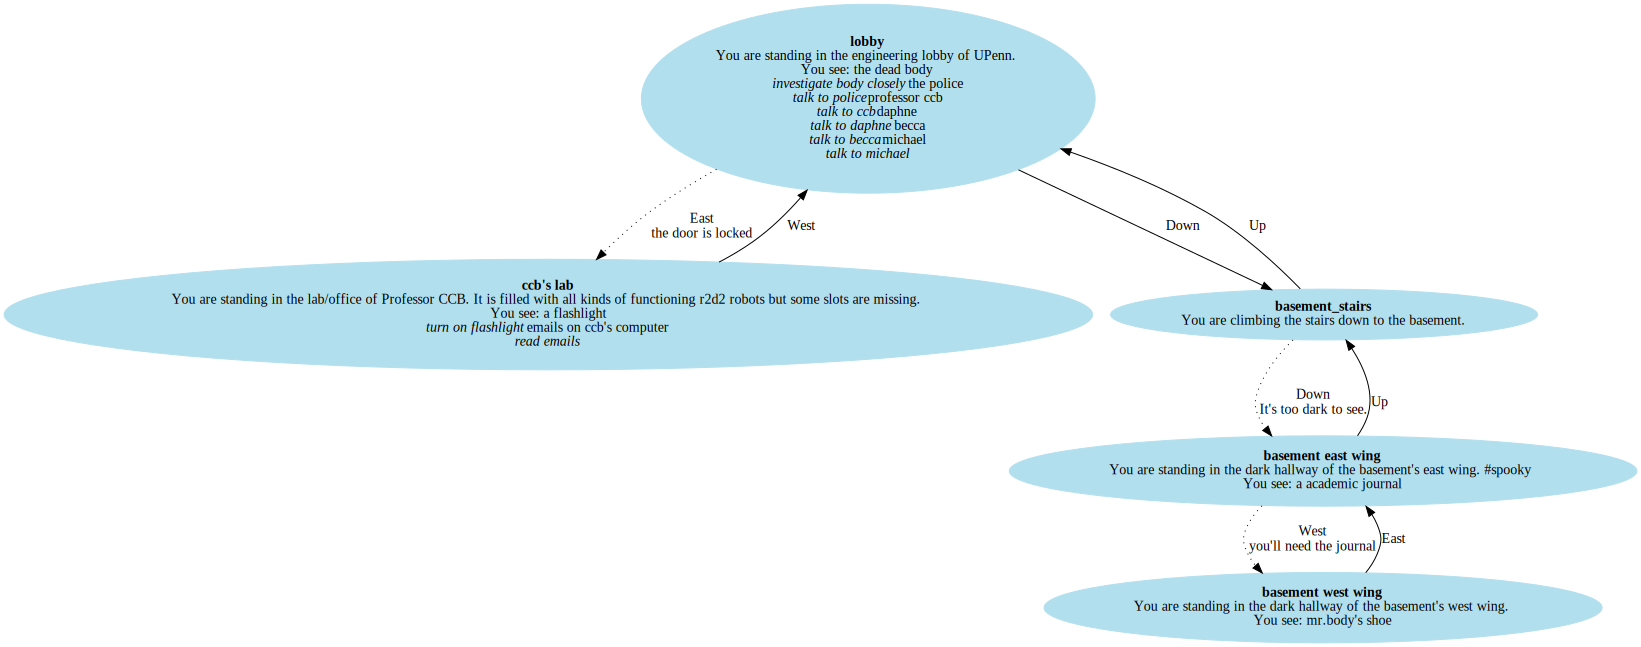

In [11]:
#!pip install graphviz
from graphviz import Digraph
from IPython.display import Image
import queue

def DFS(game, graph):
  """Do a depth-first-search traversal of the locations in the game
     starting at the start location, and create a GraphViz graph 
     to vizualize the connections between the locations, and the items
     that are located at each location."""
  start_location = game.curr_location
  frontier = queue.Queue()
  frontier.put(start_location)
  visited = {}
  visited[start_location.name] = True

  while not frontier.empty():
    current_location = frontier.get()
    game.curr_location = current_location
    name = current_location.name
    description = current_location.description
    items = current_location.items
    items_html = describe_items(current_location)
    html = "<<b>%s</b><br />%s<br />%s>" % (name, description, items_html)
    # Create a new node in the graph for this location
    graph.node(name, label=html)  

    connections = current_location.connections
    for direction in connections.keys():
      next_location = connections[direction]
      if not current_location.is_blocked(direction, game):
        # Create an edge between the current location and its successor
        graph.edge(name, next_location.name, label=direction.capitalize())
      else:
        # Create a dotted edge for connected locations that are blocked
        block_description = "%s\n%s" % (direction.capitalize(), current_location.get_block_description(direction))
        graph.edge(name, next_location.name, label=block_description, style="dotted")
      if not next_location.name in visited:
        visited[next_location.name] = True
        frontier.put(next_location)

def describe_items(location, print_commands=True):
    """Describe what objects are in the current location."""
    items_html = ""
    if len(location.items.keys()) > 0:
      items_html = "You see: "
    for item_name in location.items:
      item = location.items[item_name]
      items_html += item.description
      if print_commands:
        special_commands = item.get_commands()
        for cmd in special_commands:
          items_html += "<br/><i>%s</i>" % cmd
    return items_html

def save_to_drive(graph):
  from google.colab import drive
  drive.mount('/content/drive/')
  graph.render('/content/drive/My Drive/game-visualization', view=True)  

graph = Digraph(node_attr={'color': 'lightblue2', 'style': 'filled'})
game = build_game()
DFS(game, graph)
#save_to_drive(graph)
graph
